In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from qiskit.providers import BaseBackend
from qiskit.providers.models import QasmBackendConfiguration
from qiskit.result import Result
from qiskit.test import QiskitTestCase
from qiskit_experiments.measurement.discriminator import (DiscriminatorExperiment, DiscriminatorAnalysis, 
                                                          MixedDiscriminatorExperiment, MixedDiscriminatorAnalysis)

In [2]:
class DiscriminatorBackend(BaseBackend):
    """
    A simple backend that generates gaussian data for discriminator tests
    """

    def __init__(self, seed=None):
        """
        Initialize the discriminator backend
        """
        configuration = QasmBackendConfiguration(
            backend_name="discriminator_simulator",
            backend_version="0",
            n_qubits=int(1e6),
            basis_gates=["x", "measure"],
            gates=[],
            local=True,
            simulator=True,
            conditional=False,
            open_pulse=False,
            memory=False,
            max_shots=int(1e6),
            coupling_map=None,
        )

        super().__init__(configuration)
        self.rng = np.random.default_rng(seed)

    def sample_gaussian(self, centroid=np.array([0,0]), cov=np.array([[0.1,0],[0,0.1]]), size=1):
        """
        Draws random samples from a gaussian distribution.
        """
        return self.rng.multivariate_normal(centroid, cov, size)

    # pylint: disable = arguments-differ
    def run(self, qobj):
        """
        Run the discriminator backend
        """

        shots = qobj.config.shots

        result = {
            "backend_name": "Discriminator backend",
            "backend_version": "0",
            "qobj_id": 0,
            "job_id": 0,
            "success": True,
            "results": [],
        }

        for circ in qobj.experiments:
            nqubits = circ.config.n_qubits
            centroids = np.zeros([nqubits, 2])
            counts = dict()
            memory = np.zeros([shots, circ.config.memory_slots, 2])

            for i in range(shots):
                clbits = np.zeros(circ.config.memory_slots, dtype=int)
                meas_res = 0
                for op in circ.instructions:
                    qubit = op.qubits[0]
                    if op.name == "x":
                        meas_res=1
                    elif op.name == "measure":
                        # centroid is either (0,0) for |0> or (1,1) for |1>
                        memory[i, op.memory[0]] = self.sample_gaussian(centroid=np.array([meas_res, meas_res]))
                        clbits[op.memory[0]] = meas_res

                clstr = ""
                for clbit in clbits[::-1]:
                    clstr = clstr + str(clbit)

                if clstr in counts:
                    counts[clstr] += 1
                else:
                    counts[clstr] = 1

            result["results"].append(
                {
                    "shots": shots,
                    "success": True,
                    "header": {"metadata": circ.header.metadata},
                    "data": {"counts": counts, "memory": memory},
                }
            )

        return Result.from_dict(result)

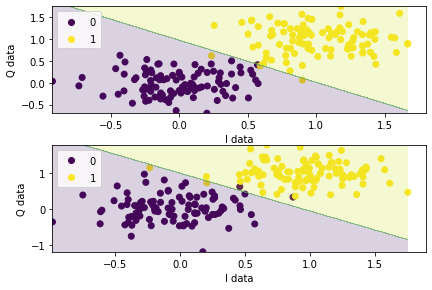

In [3]:
backend = DiscriminatorBackend(0)
exp = DiscriminatorExperiment(2)
res = exp.run(
    backend,
    shots=100,
    meas_level=1,
    meas_return='single',
    discriminator_type="LDA"
)

In [4]:
from qiskit_experiments.data_processing.data_processor import DataProcessor
from qiskit_experiments.data_processing.exceptions import DataProcessorError
from qiskit_experiments.data_processing.nodes import (
    ToReal,
    ToRealAvg,
    ToImag,
    ToImagAvg,
    Probability,
    LDADiscriminator,
    QDADiscriminator
)

processor = DataProcessor("memory", [LDADiscriminator(res)])
processor.append(Probability("00"))
datum = processor(res.data(0))

print(datum)

(0.98, 0.014000000000000005)


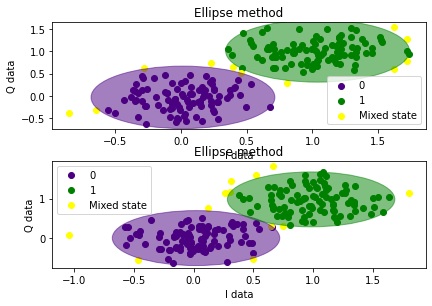

In [5]:
backend = DiscriminatorBackend()
exp = MixedDiscriminatorExperiment(2)
res = exp.run(
    backend,
    shots=100,
    meas_level=1,
    meas_return='single',
    discriminator_type="EM",
    distance=[[0.7,0.7]]*2
)